# Climate-date autoencoder

To try and isolate the effect of climate and date, let's try and learn a sparse and low-rank encoding of a waterbody. Given this encoding, the climate drivers, and the time of year, we should then be able to predict the waterbody level, even without anything else.

## Setup

### Load modules

In [2]:
import sys

import h5py
import cmocean.cm
import datacube
import geopandas as gpd
import matplotlib.animation
import matplotlib.colors
import matplotlib.patches
import numpy as np
import scipy.cluster
import scipy.ndimage.filters
import sklearn.cluster
import sklearn.decomposition
import sklearn.pipeline
import sklearn.preprocessing
import statsmodels.tsa.stattools
from matplotlib import pyplot as plt
from scipy import optimize as opt
from tqdm.notebook import tqdm
import pandas as pd
import xarray
from statsmodels.tsa.seasonal import STL
from tensorflow import keras
from tensorflow.keras import layers

sys.path.insert(1, "../Scripts")
import dea_plotting
import mattplot

%matplotlib inline

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/g/data/v10/public/

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)

### Load the data

This was generated in LoadWaterbodies.ipynb.

In [4]:
waterbodies = gpd.read_file('waterbodies_joined_drainage.shp').to_crs('EPSG:3577')
waterbodies = waterbodies.set_index('UID')
history_file = h5py.File('interpolated_waterbodies_by_division.h5', mode='r')
dates = pd.to_datetime([l.decode('ascii') for l in history_file['dates']])

Download climate data, if you need to.

In [5]:
%%bash
# wget https://data.longpaddock.qld.gov.au/SeasonalClimateOutlook/SouthernOscillationIndex/SOIDataFiles/DailySOI1933-1992Base.csv
# wget https://stateoftheocean.osmc.noaa.gov/sur/data/dmi.nc
# wget ftp://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.aao.index.b790101.current.ascii

Unload all python modules, if you experience any issues.


Then read them in and convert to a daily time series.

In [6]:
soi = pd.read_csv('DailySOI1933-1992Base.csv')
soi_dates = []
for s in soi.itertuples():
    soi_dates.append(pd.Timestamp(year=s.Year, day=1, month=1) + pd.Timedelta(s.Day, unit='D'))
soi_dates = np.array(soi_dates)
soi['Date'] = soi_dates
soi.set_index('Date', inplace=True)

In [7]:
dmi = xarray.open_dataarray('dmi.nc')
dmi_df = pd.DataFrame({'DMI': dmi.to_pandas()})
dmi_df.index.name = 'Date'
dmi_df.index = np.array(dmi_df.index).astype('datetime64[D]')

In [8]:
aao = pd.read_csv('norm.daily.aao.index.b790101.current.ascii', sep='\s+', names=['Year', 'Month', 'Day', 'AAO'], skiprows=[8885])
# 8885 has a bunch of asterisks instead of the AAO.
aao_dates = pd.to_datetime(aao[['Year', 'Month', 'Day']])
aao.index = aao_dates

In [9]:
rolling_aao = aao.AAO.rolling(28).mean()
rolling_soi = soi.SOI.rolling(28).mean()
rolling_dmi = dmi_df.DMI.rolling(28).mean()

In [10]:
time_of_year = dates.dayofyear / 366 * np.pi * 2

In [11]:
sine = np.sin(time_of_year)
cosine = np.cos(time_of_year)

In [12]:
days = pd.DateOffset(days=1)

In [13]:
climate = np.stack([
    aao.AAO.resample('1D').mean().reindex(dates).ffill().bfill(),
    soi.SOI.resample('1D').mean().reindex(dates).ffill().bfill(),
    dmi_df.DMI.resample('1D').mean().reindex(dates).ffill().bfill(),
    sine,
    cosine,
]).T

The plan here is to have two networks: an encoder and a predictor. The encoder maps a waterbody observation time series to an encoding of that waterbody, and the predictor takes an encoding and the climate and predicts the original time series. The original time series should be the gradient, so that it's wide-sense stationary. We will work only with one region of Australia for now, and that will be Tasmania since it's pretty small and nice. Tasmania should be heavily influenced by SAM and also influenced by ENSO and IOD.

In [14]:
tasmania = history_file['Tasmania']['pc_wet']

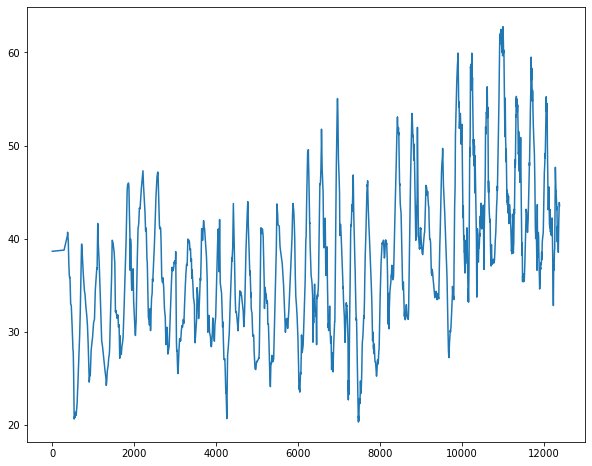

In [15]:
plt.plot(np.nanmean(tasmania, axis=0))

We'll use segments of 365 days (a year) and a convolutional autoencoder. For training, we'll use only the last 1200 days of data, which is about 10% of the data.

In [16]:
def make_sequences(history: 'N x T', climate: '5 x T', seq_length=365, seq_step=50):
    assert history.shape[1] == climate.shape[1]
    history_seqs = []
    climate_seqs = []
    for i in range(0, history.shape[1] - seq_length, seq_step):
        history_seqs.append(history[:, i:i + seq_length, None])  # N x T x 1
        climate_seq = climate[:, i:i + seq_length].T[None, :, :]  # T x 5
        climate_seqs.append(np.tile(climate_seq, [len(history), 1, 1]))  # 5 x T
        # Want: N x T x 1, N x T x 5
    return np.concatenate(history_seqs, axis=0), np.concatenate(climate_seqs, axis=0)

In [17]:
history_seqs, climate_seqs = make_sequences(np.nan_to_num(tasmania[:, -1200:]), climate.T[:, -1200:])

In [18]:
history_seqs.shape, climate_seqs.shape

((111979, 365, 1), (111979, 365, 5))

Then build the model. This will be a RNN model, which seems to be easier than dealing with convolutional layers.

In [19]:
mean_history_seq = history_seqs.mean(axis=0)
history_seqs -= mean_history_seq
max_history_seq = abs(history_seqs).max(axis=0)
history_seqs /= max_history_seq

In [20]:
mean_climate_seq = climate_seqs.mean(axis=0)
climate_seqs -= mean_climate_seq
max_climate_seq = abs(climate_seqs).max(axis=0)
climate_seqs /= max_climate_seq

In [21]:
history_seqs.shape

(111979, 365, 1)

In [96]:
inputs = keras.Input(shape=(365, 1))  # N x T x 1
x = layers.AvgPool1D(4)(inputs)  # downsampling to N x T / 4 x 1
encoding = layers.LSTM(8, activation='tanh')(x)  # N x 8
encoder = keras.Model(inputs=inputs, outputs=encoding)

climate_inputs = keras.Input(shape=(365, 5))  # N x T x 5
repeated = layers.RepeatVector(365)(encoding)  # N x T x 8
x = layers.Concatenate()([repeated, climate_inputs])  # N x T x 13
x = layers.LSTM(8, return_sequences=True, activation='tanh')(x)  # N x 365 x 8
x = layers.Dense(1, activation='tanh')(x)
x = layers.Reshape((365,))(x)

model = keras.Model(inputs=[inputs, climate_inputs], outputs=x)
model.compile(optimizer='adam', loss='mse')

In [100]:
model.fit([history_seqs[::500], climate_seqs[::500]], epochs=100)

Epoch 1/100
224/224 [==============================] - 3s 13ms/sample - loss: 0.0211
Epoch 2/100
224/224 [==============================] - 3s 13ms/sample - loss: 0.0137
Epoch 3/100
224/224 [==============================] - 3s 13ms/sample - loss: 0.0100
Epoch 4/100
224/224 [==============================] - 3s 12ms/sample - loss: 0.0079
Epoch 5/100
224/224 [==============================] - 3s 12ms/sample - loss: 0.0066
Epoch 6/100
224/224 [==============================] - 3s 12ms/sample - loss: 0.0058
Epoch 7/100
224/224 [==============================] - 3s 12ms/sample - loss: 0.0052
Epoch 8/100
224/224 [==============================] - 3s 12ms/sample - loss: 0.0047
Epoch 9/100
224/224 [==============================] - 3s 12ms/sample - loss: 0.0043
Epoch 10/100
224/224 [==============================] - 3s 13ms/sample - loss: 0.0040
Epoch 11/100
224/224 [==============================] - 3s 13ms/sample - loss: 0.0037
Epoch 12/100
224/224 [==============================] - 3s 13ms

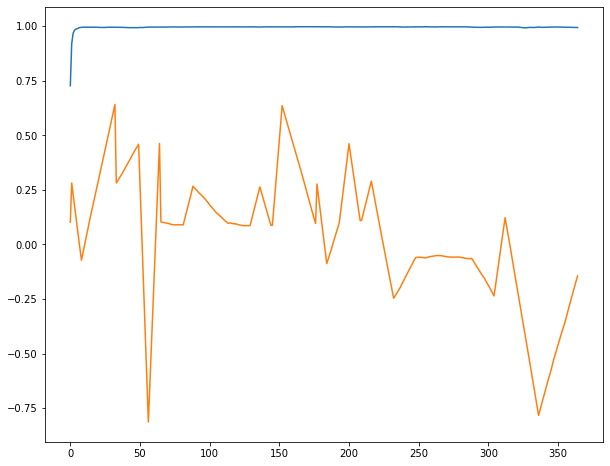

In [101]:
plt.plot(model.predict([history_seqs[:1], climate_seqs[:1]]).mean(axis=0))
plt.plot(history_seqs[:1].mean(axis=0))

In [102]:
p = encoder.predict(history_seqs[::500])
import sklearn.decomposition
pca_f = sklearn.decomposition.PCA(n_components=2).fit_transform(p)

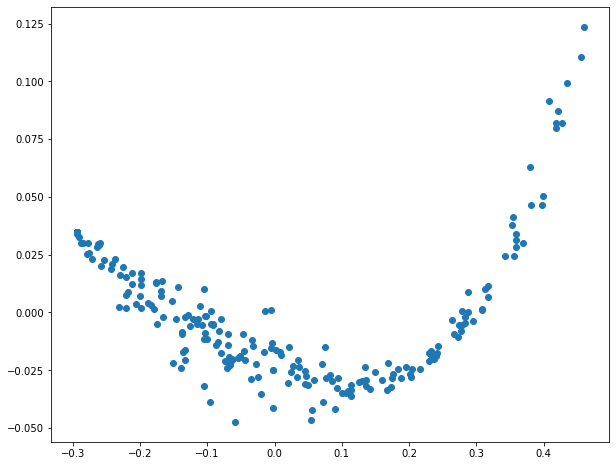

In [103]:
plt.scatter(*pca_f.T)